In [1]:
import torch
import numpy as np
import os
import datetime
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

train_on_gpu=torch.cuda.is_available()

print(train_on_gpu)

now = str(datetime.datetime.now()).split('.')[0].replace(":", "-")
base_path = "./model_result/baseline/"
os.makedirs(base_path+now)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True


Load the Data

In [2]:
number_of_workers = 0
batch_size= 10
valid_size= 0.2

#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])

In [3]:
# Downloading training and testing Datasets
train_data= datasets.CIFAR10('./data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('./data', train = False,
                             download = True, transform= transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 35158998.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]

In [5]:
# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size, 
                                         num_workers= number_of_workers)

In [7]:
# After preparing Data, we have to unnormalize it to visullize it.
# Let‘s create a helper function which will un-normalize all the images
def imshow(img):
  # Will take numpy array as input
  img = img / 2 + 0.5 # Unnormalize image
  plt.imshow(np.transpose(img, (1, 2, 0))) # img array , axis in tuple(numbers indicates the location of new image shape.) Converting from tensor image 

In [8]:
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

In [10]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.conv1 = nn.Conv2d(3, 6, 2 , padding=1, stride= 1) # (32 - 5+ 2(0) / 1) + 1 = 28
        self.pool1 = nn.MaxPool2d(2, 2) # (28 - 2 + 2(0)/ 2) + 1 = 14
        self.conv2 = nn.Conv2d(6, 16, 2, padding=1, stride= 1) # (14 - 5 + 2(0)/ 1) + 1 = 10
        self.pool2 = nn.MaxPool2d(2, 2) # (10 - 2 + 2(0)/ 2) + 1 = 5
        self.conv3 = nn.Conv2d(16, 32, 2)# (5 - 2 + 2(0)/ 1) + 1 = 4
        self.pool3 = nn.MaxPool2d(2, 2)# (4 - 2 + 2(0)/ 2) + 1 = 2
        self.fc1 = nn.Linear(32* 3**2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool1( F.relu(self.conv1(x)))
        x= self.pool2( F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
        # Flatten it
        x= torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr= 0.0001, momentum= 0.9)
#optimizer = optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)


In [12]:
t0 = time.time()
# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

# keeping track of losses as it happen
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    correct = 0
    total = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class (get the index of the max probability)
        _, predicted = torch.max(model(data), 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    print('Epoch: {} \tTraining Accuracy: {:.2f}% \tValidation Accuracy: {:.2f}%'.format(
    epoch, train_accuracy, valid_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

t1 = time.time()
print('Time cost: ', t1 - t0)

Epoch: 1 	Training Loss: 1.842106 	Validation Loss: 0.460241
Epoch: 1 	Training Accuracy: 11.65% 	Validation Accuracy: 11.65%
Validation loss decreased (inf --> 0.460241).  Saving model ...
Epoch: 2 	Training Loss: 1.839603 	Validation Loss: 0.459570
Epoch: 2 	Training Accuracy: 11.62% 	Validation Accuracy: 11.62%
Validation loss decreased (0.460241 --> 0.459570).  Saving model ...
Epoch: 3 	Training Loss: 1.836157 	Validation Loss: 0.458321
Epoch: 3 	Training Accuracy: 15.57% 	Validation Accuracy: 15.57%
Validation loss decreased (0.459570 --> 0.458321).  Saving model ...
Epoch: 4 	Training Loss: 1.827674 	Validation Loss: 0.454689
Epoch: 4 	Training Accuracy: 18.28% 	Validation Accuracy: 18.28%
Validation loss decreased (0.458321 --> 0.454689).  Saving model ...
Epoch: 5 	Training Loss: 1.801230 	Validation Loss: 0.444572
Epoch: 5 	Training Accuracy: 19.00% 	Validation Accuracy: 19.00%
Validation loss decreased (0.454689 --> 0.444572).  Saving model ...
Epoch: 6 	Training Loss: 1.752

In [13]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

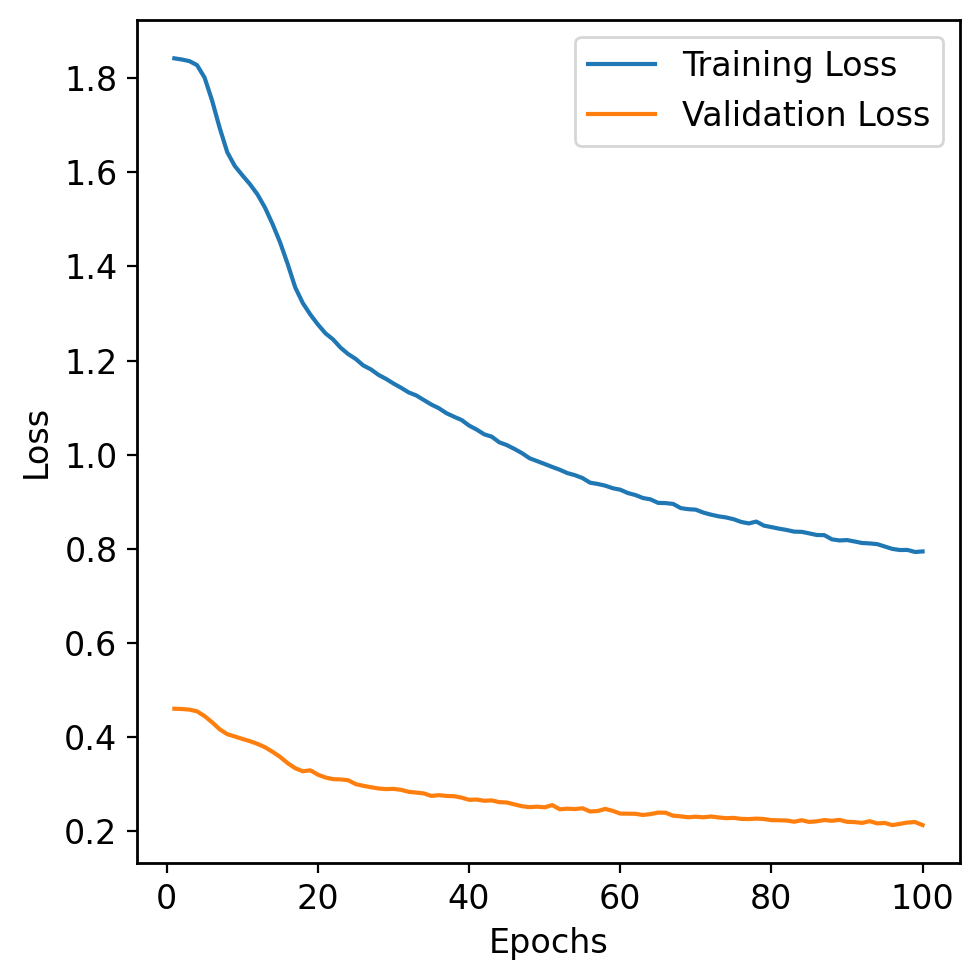

In [14]:
epochs = range(1, n_epochs + 1)

# Set font sizes
fontsize = 12

plt.figure(figsize=(5, 5), dpi=200)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')


# Set title and labels with black color and increased font size
plt.xlabel('Epochs', color='black', fontsize=fontsize)
plt.ylabel('Loss', color='black', fontsize=fontsize)

# Set the color of the ticks and increase their font size
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Add legend with increased font size
plt.legend(fontsize=fontsize)
# Set grid to false
plt.grid(False)
plt.tight_layout()

# Create a black border around the plot
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "loss_baseline.png")

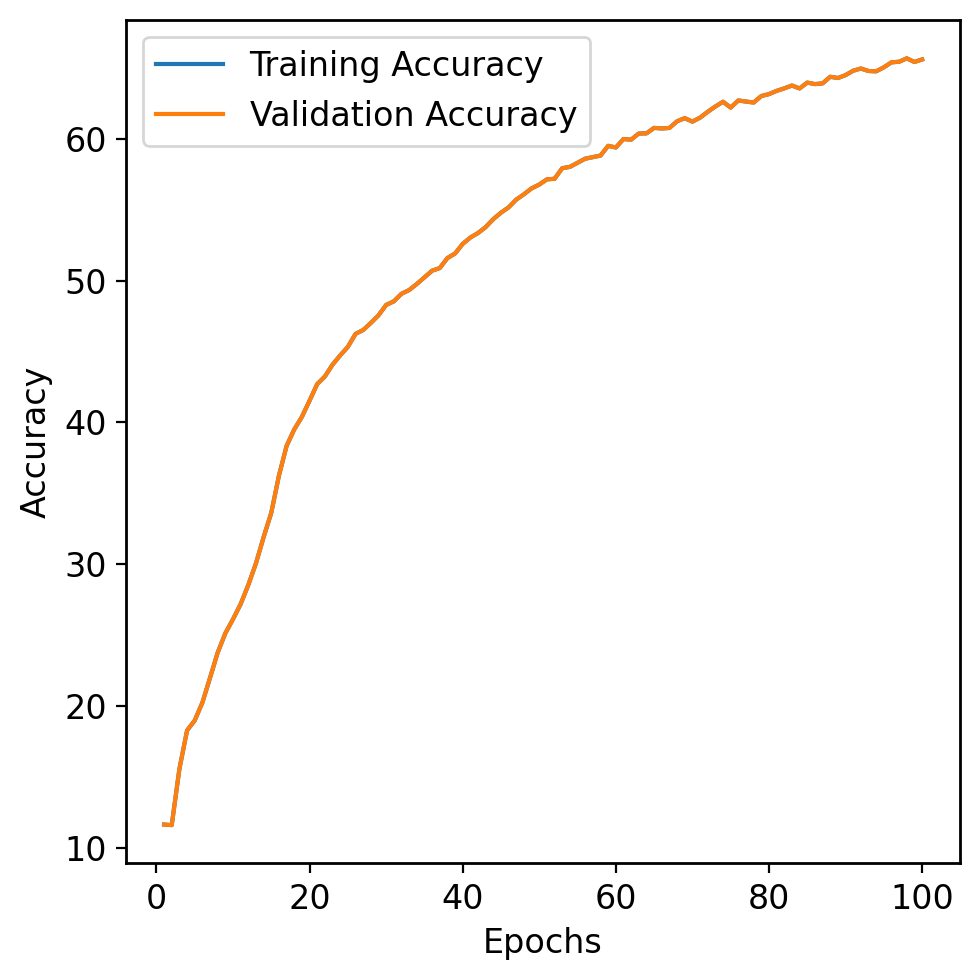

In [15]:
plt.figure(figsize=(5, 5), dpi=200)

# Plotting the accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')

# Set title and labels with specific color
plt.xlabel('Epochs', color='black', fontsize=fontsize)
plt.ylabel('Accuracy', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Adding the legend
plt.legend(fontsize=fontsize)

# Setting grid to false
plt.grid(False)
plt.tight_layout()

# Create a black border around the plot
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "accuracy_baseline.png")

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = np.zeros((10, 10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # Update confusion matrix
    for label, prediction in zip(target.view(-1), pred.view(-1)):
        confusion_matrix[label.long(), prediction.long()] += 1
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

confusion_matrix = confusion_matrix.astype(int)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.055223

Test Accuracy of Airplane: 66% (661/1000)
Test Accuracy of Automobile: 74% (744/1000)
Test Accuracy of  Bird: 50% (505/1000)
Test Accuracy of   Cat: 38% (383/1000)
Test Accuracy of  Deer: 48% (488/1000)
Test Accuracy of   Dog: 55% (553/1000)
Test Accuracy of  Frog: 79% (794/1000)
Test Accuracy of Horse: 67% (675/1000)
Test Accuracy of  Ship: 76% (766/1000)
Test Accuracy of Truck: 66% (662/1000)

Test Accuracy (Overall): 62% (6231/10000)


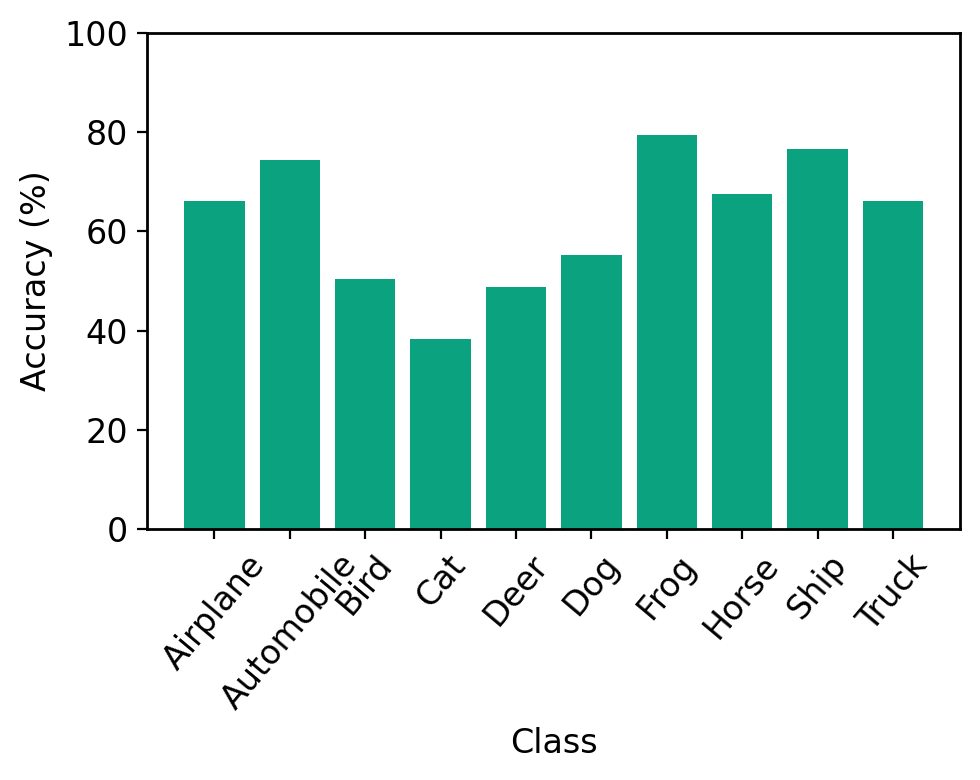

In [17]:
# Calculate the percentage accuracy for each class
class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] else 0 for i in range(10)]

plt.figure(figsize=(5, 4), dpi=200)
plt.bar(class_names, class_accuracy, color='#0BA37F')

# Set title and labels with black color
plt.xlabel('Class', color='black', fontsize=fontsize)
plt.ylabel('Accuracy (%)', color='black', fontsize=fontsize)

# Set the color of the ticks to black
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Rotate x-ticks and set y-axis limit
plt.xticks(rotation=50)
plt.ylim([0, 100])  # Limit y-axis to 0-100% for clarity

# Set grid to false and create a black border around the plot
plt.grid(False)
plt.tight_layout()
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "accuracy_bar_baseline.png")

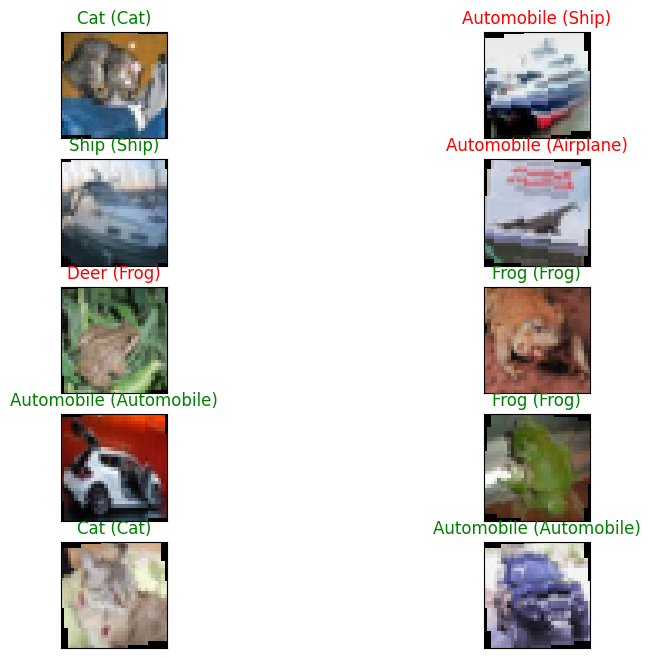

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(10, 8))
plt.tight_layout()
for idx in np.arange(10):
    ax = fig.add_subplot(5, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
plt.savefig(base_path + "classcify_example_baseline.png")

Confusion Matrix:
 [[661  42  52  16   7   9  12  13 144  44]
 [ 40 744   7   9   3   8  13   3  64 109]
 [ 77  19 505  57  83  75  96  54  17  17]
 [ 18  34  82 383  55 198 123  54  28  25]
 [ 38  12 110  52 488  45 123 100  17  15]
 [ 13  10  84 139  43 553  57  74  11  16]
 [  9  15  50  47  22  20 794  14  10  19]
 [ 25   8  36  43  53  90  18 675   7  45]
 [ 87  39  18  15   9  12   8   9 766  37]
 [ 36 164  12  13   5  22  14  17  55 662]]


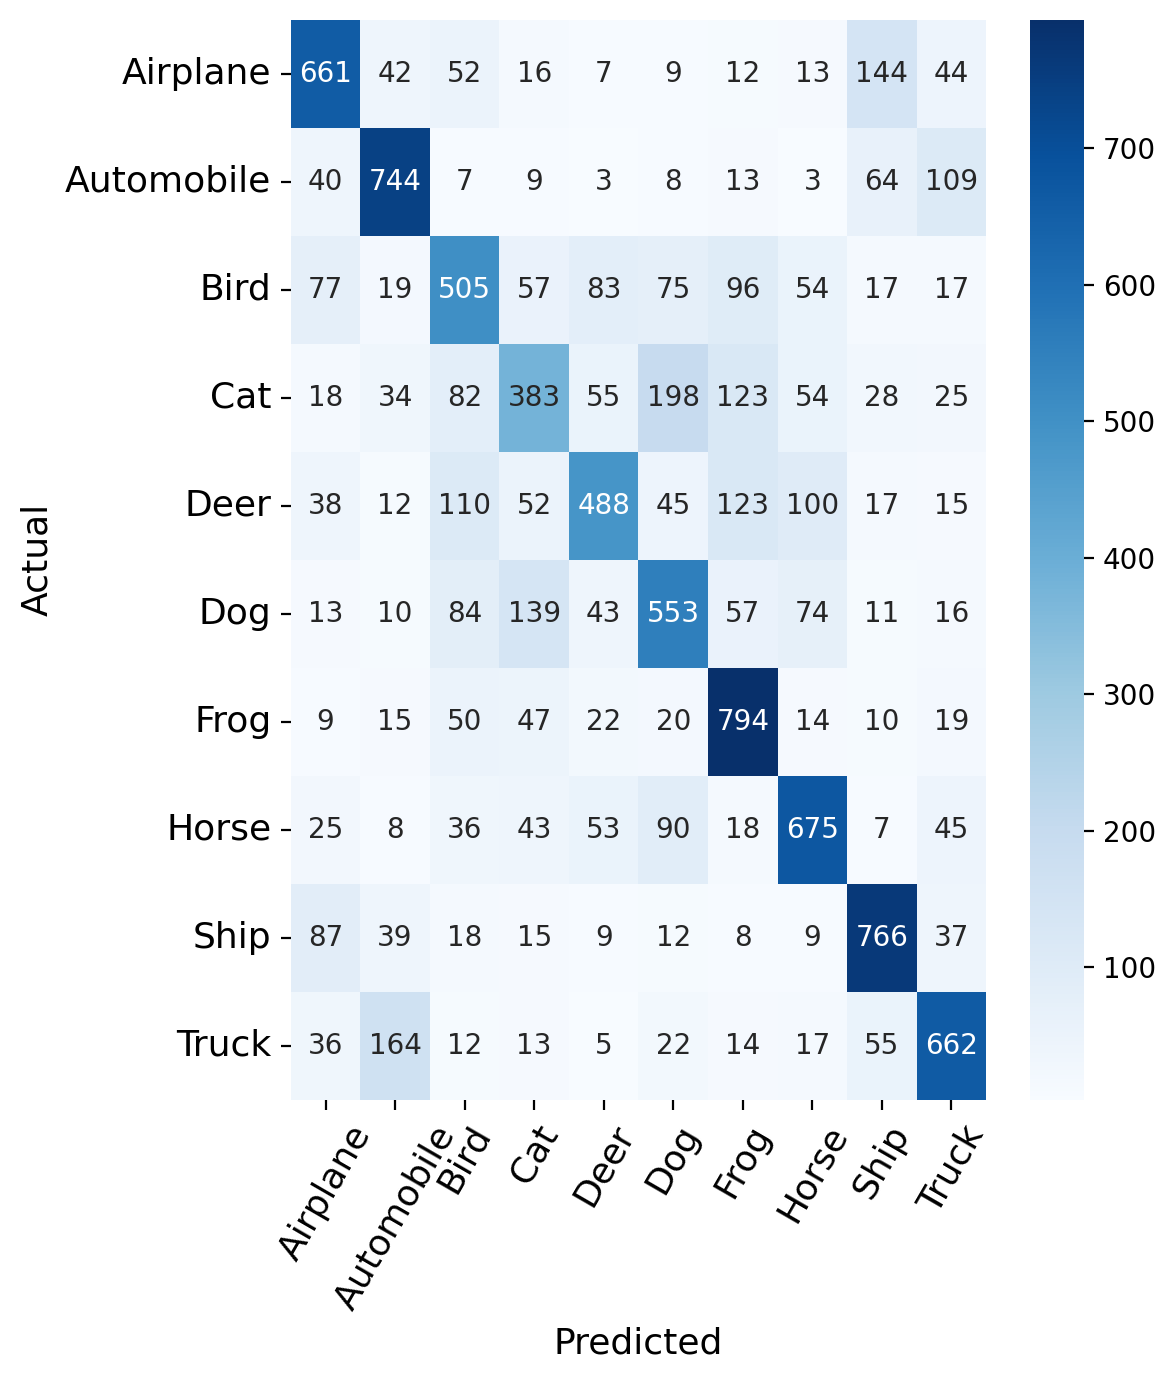

In [19]:
fontsize=13

print("Confusion Matrix:\n", confusion_matrix)

plt.figure(figsize=(6, 7), dpi=200)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

# Set title and labels with specific color
plt.ylabel('Actual', color='black', fontsize=fontsize)
plt.xlabel('Predicted', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.xticks(rotation=60, color='black')
plt.yticks(color='black')

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)
plt.tight_layout()

# Show and save the plot
# plt.show()
plt.savefig(base_path + "confusion_matrix_baseline.png")